Data from Kaggle: [Pneumonia Dataset](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia) and [Tuberculosis Dataset](https://www.kaggle.com/datasets/tawsifurrahman/tuberculosis-tb-chest-xray-dataset/code)


# PRE-PROCESSING

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

print("packages are imported")

packages are imported


In [3]:
# Train dataset
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/CS123B_Project/train',
    validation_split=0.2,
    subset="training",
    seed=123,
    labels="inferred",
    label_mode="int",
    image_size=(224, 224),
    batch_size=32
)

# Validation dataset
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/CS123B_Project/train',
    validation_split=0.2,
    subset="validation",
    seed=123,
    labels="inferred",
    label_mode="int",
    image_size=(224, 224),
    batch_size=32
)

# Load test data
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/CS123B_Project/test',
    labels='inferred',
    label_mode='int',
    image_size=(224, 224),
    batch_size=32,
    shuffle=False
)

Found 720 files belonging to 3 classes.
Using 576 files for training.
Found 720 files belonging to 3 classes.
Using 144 files for validation.
Found 180 files belonging to 3 classes.


# CNN

In [4]:
import tensorflow as tf

# 1. Load DenseNet121 without top
base_model = tf.keras.applications.DenseNet121(
    input_shape=(224, 224, 3),
    include_top=False,
    pooling=None,  # no avg pooling yet
    weights='imagenet'
)

# 2. Freeze the base model (optional at first)
base_model.trainable = False

# 3. Add your own classifier on top
inputs = tf.keras.Input(shape=(224, 224, 3))
x = tf.keras.applications.densenet.preprocess_input(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)  # optional dense layer
x = tf.keras.layers.Dropout(0.5)(x)  # optional regularization
outputs = tf.keras.layers.Dense(3, activation='softmax')(x)  # final output layer

# Build the full model
model = tf.keras.Model(inputs, outputs)

# 4. Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # or categorical_crossentropy
    metrics=['accuracy']
)


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [5]:
#NOTE: This step will take about 10 minutes to run

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=3,
    verbose=1    # show progress bar
)



Epoch 1/3
18/18 ━━━━━━━━━━━━━━━━━━━━ 189s 9s/step - accuracy: 0.5184 - loss: 1.1806 - val_accuracy: 0.8819 - val_loss: 0.3201
Epoch 2/3
18/18 ━━━━━━━━━━━━━━━━━━━━ 185s 9s/step - accuracy: 0.8365 - loss: 0.3580 - val_accuracy: 0.8958 - val_loss: 0.2636
Epoch 3/3
18/18 ━━━━━━━━━━━━━━━━━━━━ 196s 8s/step - accuracy: 0.8915 - loss: 0.2400 - val_accuracy: 0.9444 - val_loss: 0.1985


#ANALYSIS

In [7]:
# Evaluate on validation dataset
results = model.evaluate(val_dataset)
# Assuming accuracy is the second element
accuracy = results[1]
print(f"Validation Accuracy: {accuracy * 100:.2f}%")


5/5 ━━━━━━━━━━━━━━━━━━━━ 28s 5s/step - accuracy: 0.9550 - loss: 0.1732
Validation Accuracy: 94.44%


In [8]:
# Evaluate on test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

6/6 ━━━━━━━━━━━━━━━━━━━━ 52s 7s/step - accuracy: 0.9446 - loss: 0.1920
Test Accuracy: 93.89%


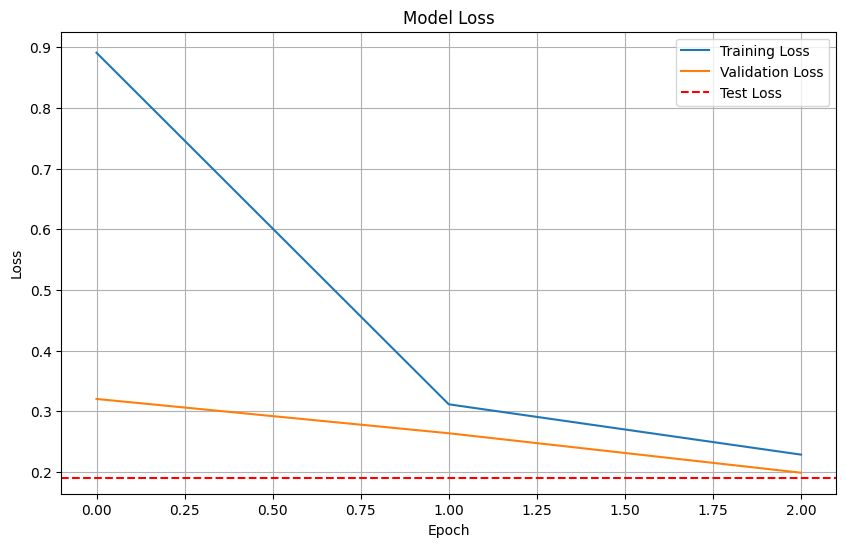

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

history_df = pd.DataFrame(history.history)

plt.figure(figsize=(10, 6))
plt.plot(history_df['loss'], label='Training Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.axhline(y=test_loss, color='red', linestyle='--', label='Test Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## Example Case

In [11]:
# 1. Load and preprocess the X-ray image
img_path = '/content/drive/MyDrive/Example_Patient_Xray.jpeg'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = tf.keras.applications.densenet.preprocess_input(img_array)

# 2. Predict
predictions = model.predict(img_array)

# 3. Find the predicted class
predicted_class_index = np.argmax(predictions[0])
class_names = ['NORMAL', 'PNEUMONIA', 'TUBERCULOSIS']  # your classes
predicted_class_name = class_names[predicted_class_index]

print(f" The model predicts: {predicted_class_name}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
 The model predicts: TUBERCULOSIS
